# Bayesian Modelling

## Bayesian probability

### Example: estimating the probability of heads in a coin toss experiment

In [36]:
# Generate a sequence of binary random variables
from scipy.stats import bernoulli, beta, uniform
p = 0.3
r = bernoulli.rvs(p, size=400)
r[:10]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

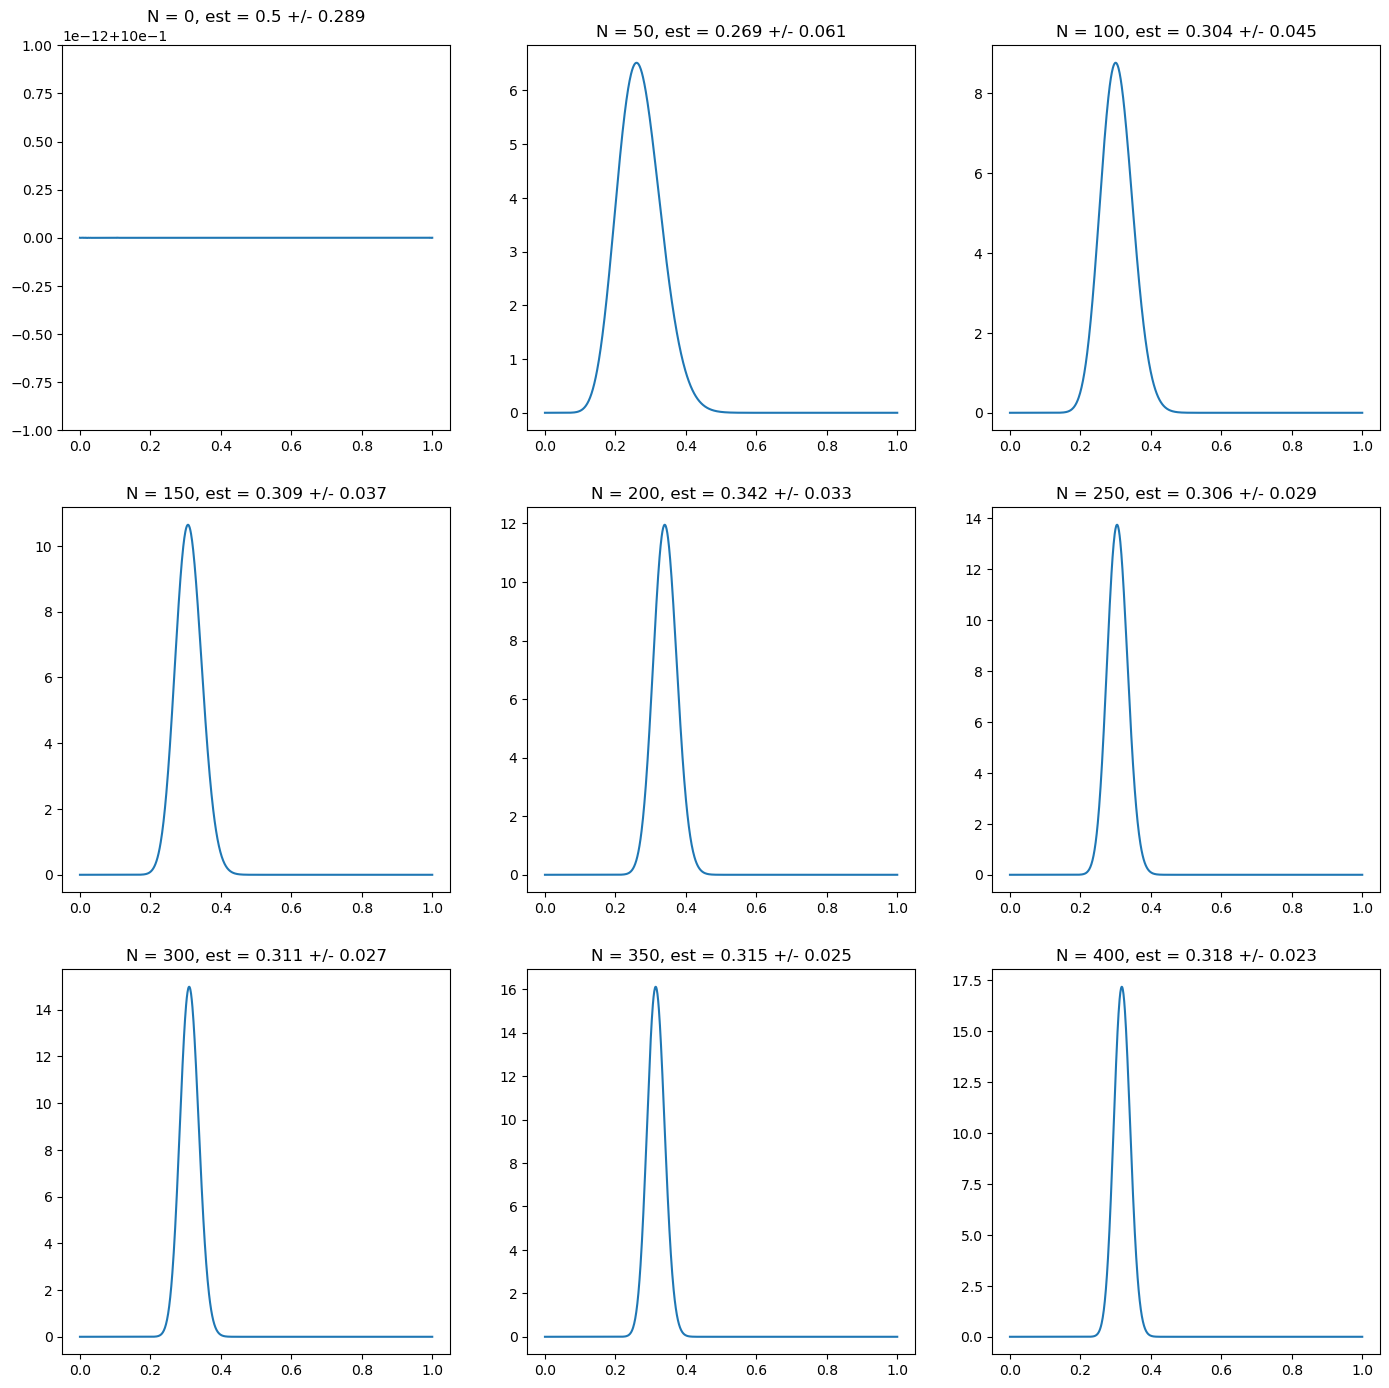

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# prior distribution: uniform prior
prior_alpha = 1
prior_beta = 1

# Now we plot the distribution as we add more data points
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17,17))
N = np.linspace(0, len(r), 9)
for i in range(9):
  n = N[i]
  i_x = int(i/3)
  i_y = i % 3 
  r_trunc = r[:int(n)]  
  p_grid = np.linspace(0, 1, 1000)
  post_alpha = prior_alpha + np.sum(r_trunc)
  post_beta = prior_beta + len(r_trunc)- np.sum(r_trunc)
  mean = beta.mean(post_alpha, post_beta)
  std = beta.std(post_alpha, post_beta)
  ax[i_x][i_y].plot(p_grid, beta.pdf(p_grid, post_alpha, post_beta))
  ax[i_x][i_y].set_title("N = " + str(int(n))+ ", est = " + str(np.round(mean, 3)) + " +/- " + str(np.round(std, 3)))

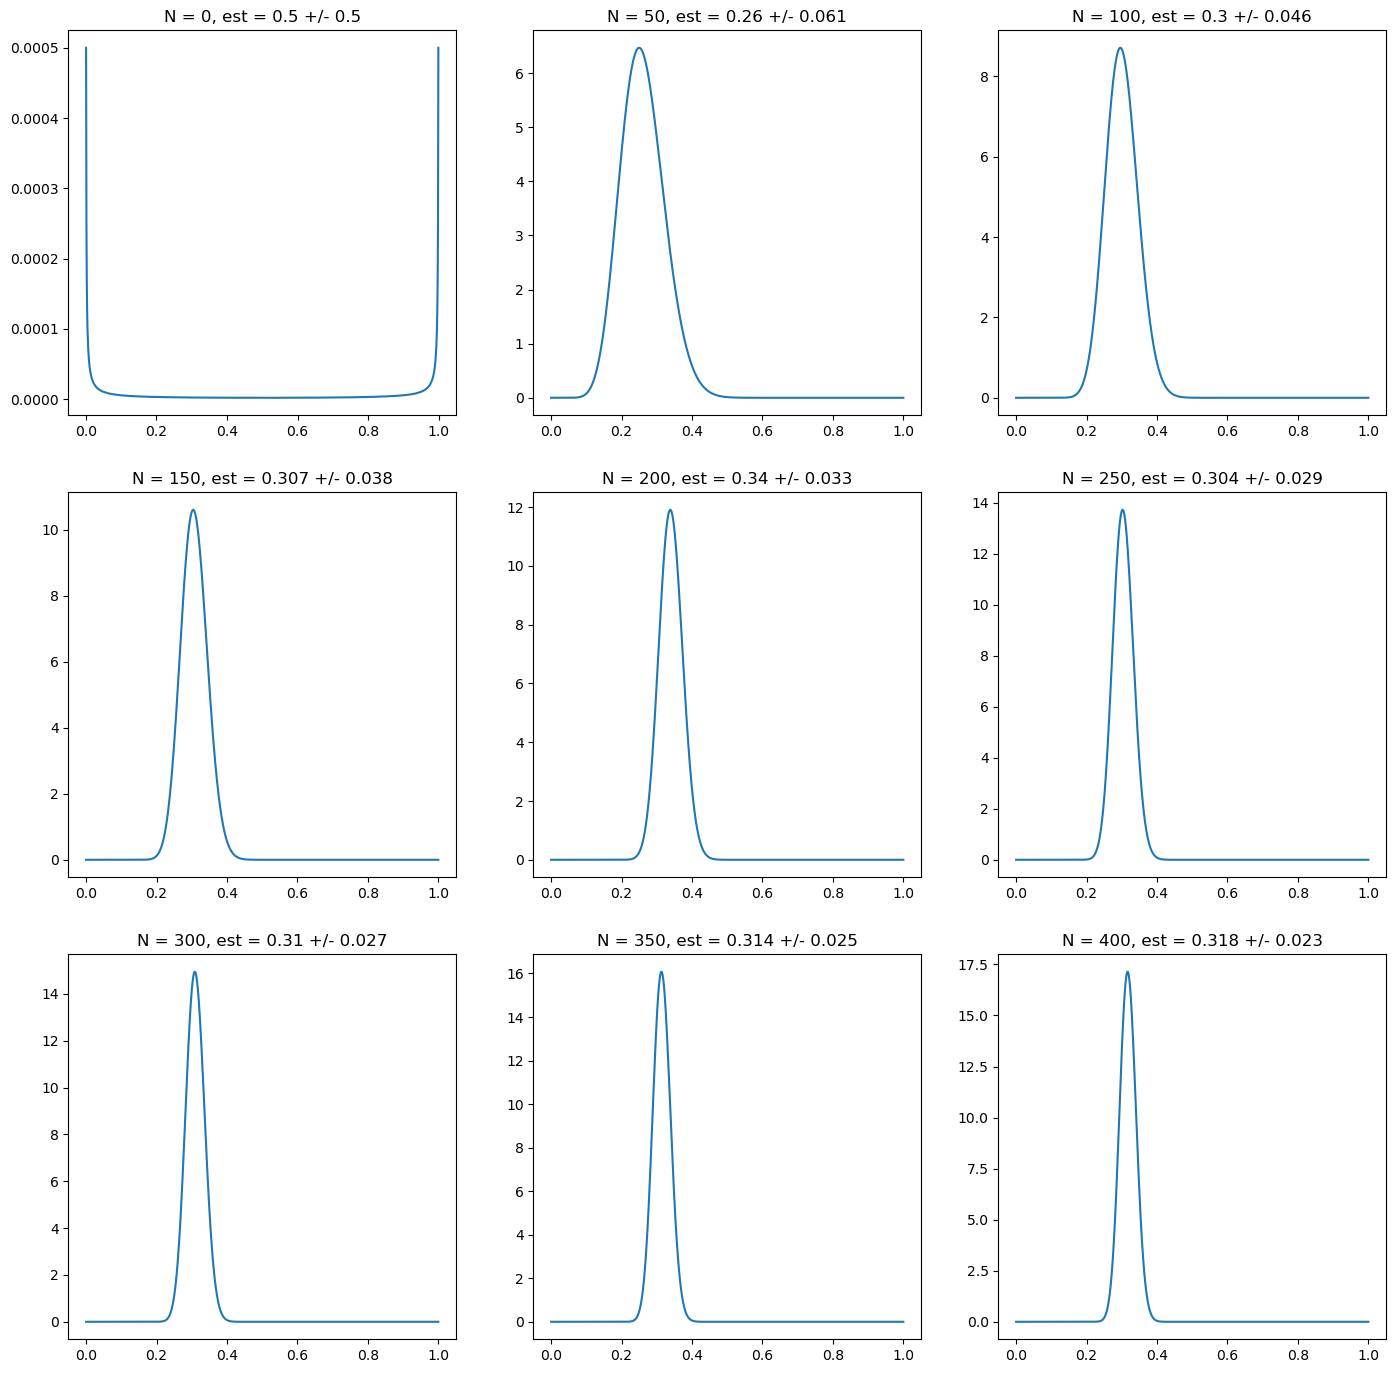

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# prior distribution: non - informative prior (approximation)
prior_alpha = 0.000001
prior_beta = 0.000001

# Now we plot the distribution as we add more data points
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17,17))
N = np.linspace(0, len(r), 9)
for i in range(9):
  n = N[i]
  i_x = int(i/3)
  i_y = i % 3 
  r_trunc = r[:int(n)]  
  post_alpha = prior_alpha + np.sum(r_trunc)
  post_beta = prior_beta + len(r_trunc)- np.sum(r_trunc)
  mean = beta.mean(post_alpha, post_beta)
  std = beta.std(post_alpha, post_beta)
  ax[i_x][i_y].plot(p_grid, beta.pdf(p_grid, post_alpha, post_beta))
  ax[i_x][i_y].set_title("N = " + str(int(n))+ ", est = " + str(np.round(mean, 3)) + " +/- " + str(np.round(std, 3)))

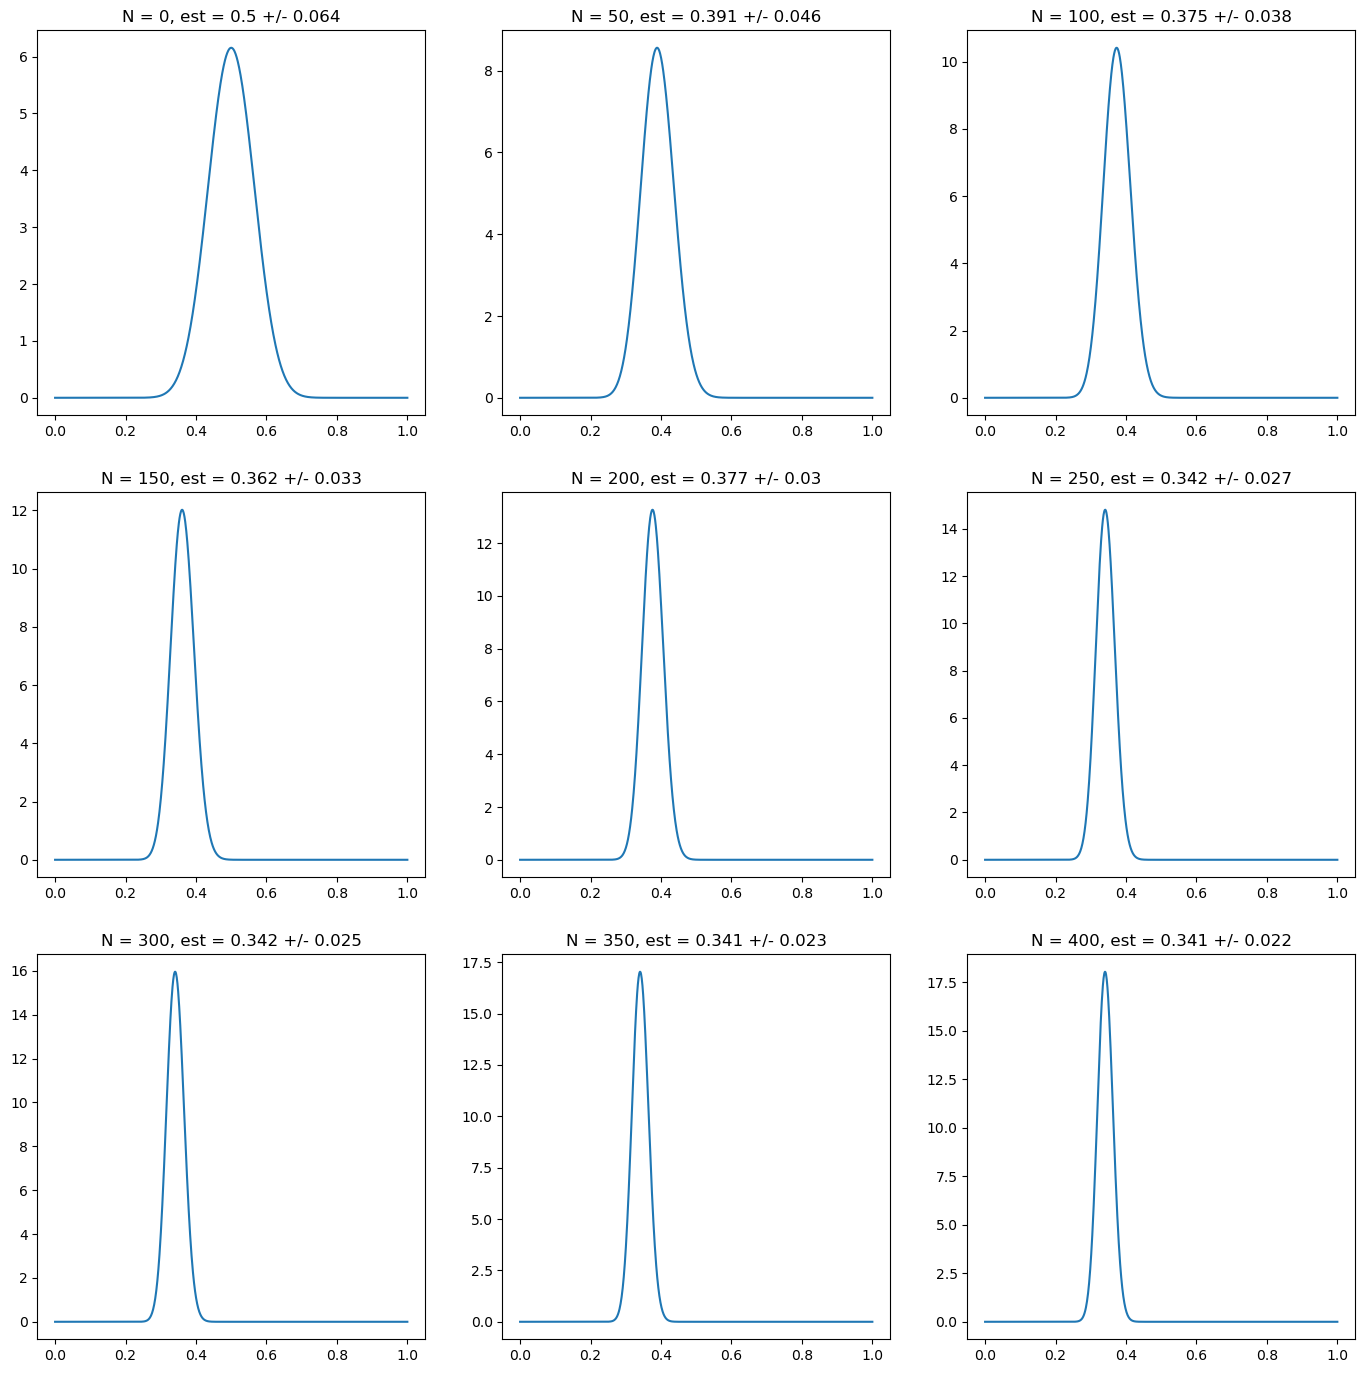

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# prior distribution: wrong confident prior
prior_alpha = 30
prior_beta = 30

# Now we plot the distribution as we add more data points
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17,17))
N = np.linspace(0, len(r), 9)
for i in range(9):
  n = N[i]
  i_x = int(i/3)
  i_y = i % 3 
  r_trunc = r[:int(n)]  
  post_alpha = prior_alpha + np.sum(r_trunc)
  post_beta = prior_beta + len(r_trunc)- np.sum(r_trunc)
  mean = beta.mean(post_alpha, post_beta)
  std = beta.std(post_alpha, post_beta)
  ax[i_x][i_y].plot(p_grid, beta.pdf(p_grid, post_alpha, post_beta))
  ax[i_x][i_y].set_title("N = " + str(int(n))+ ", est = " + str(np.round(mean, 3)) + " +/- " + str(np.round(std, 3)))

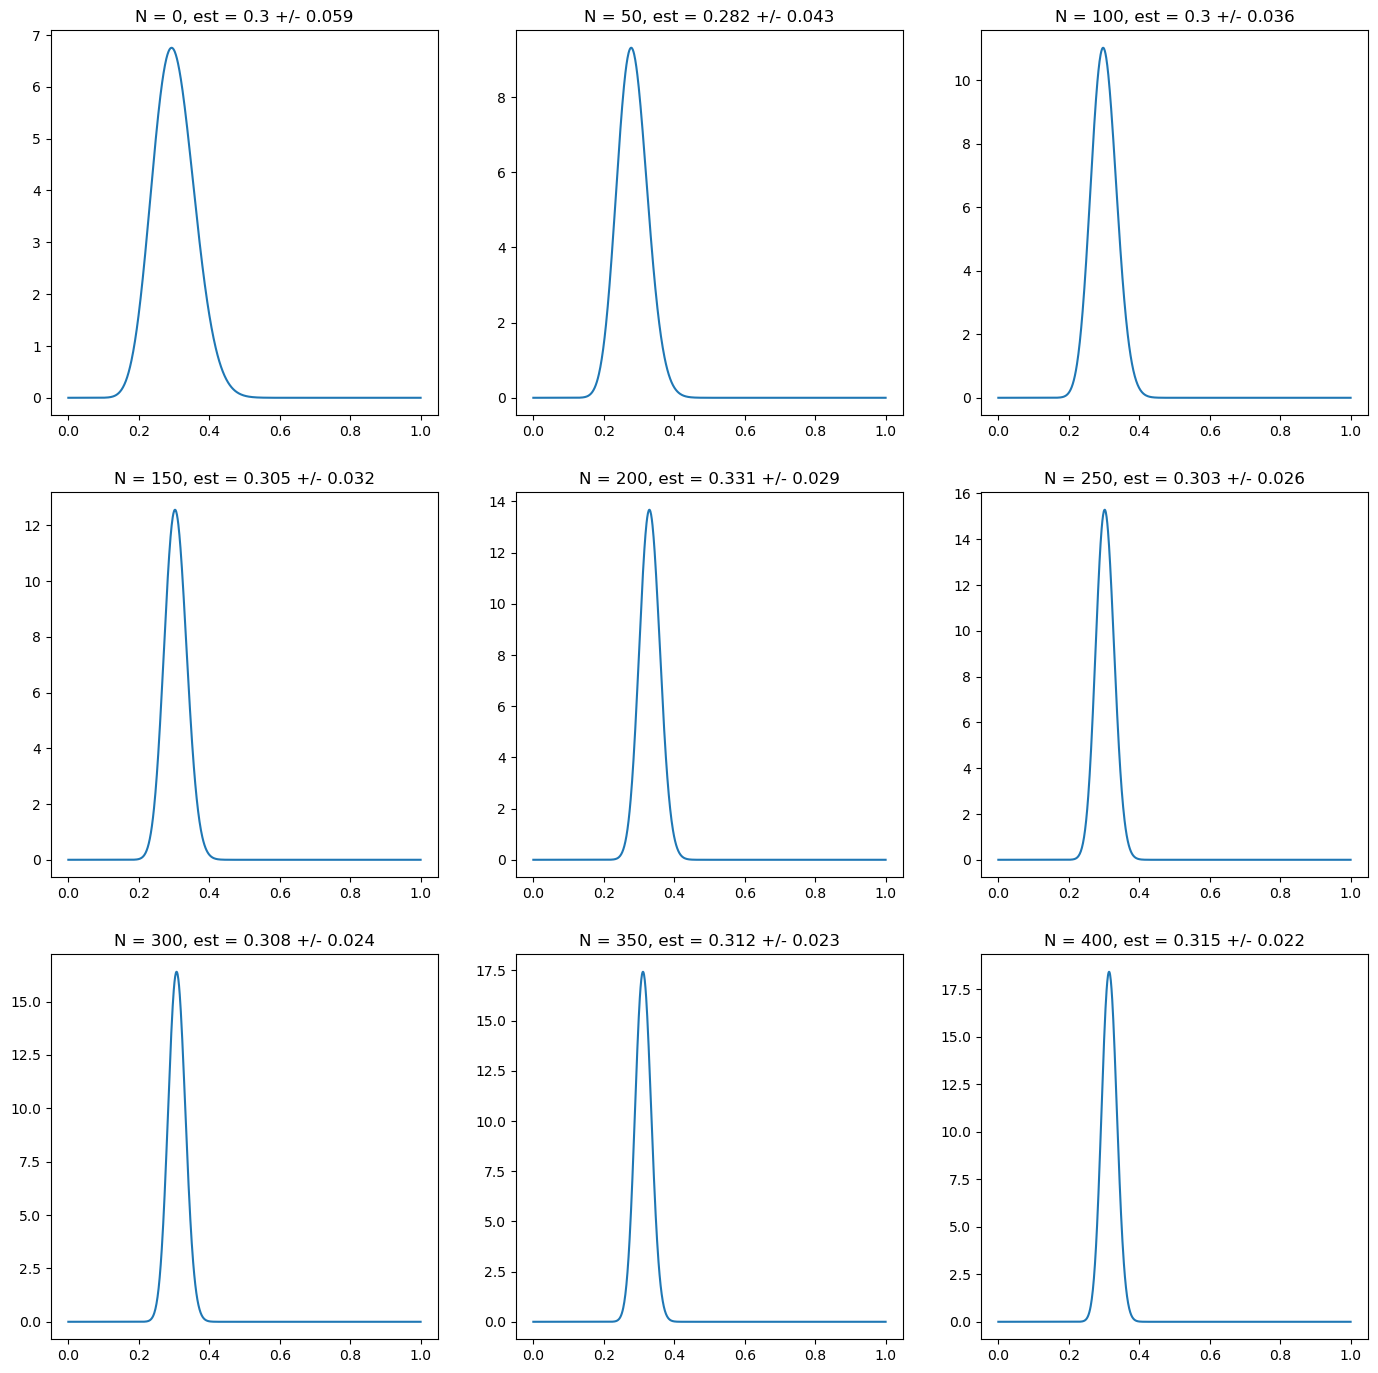

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# prior distribution: correct confident prior
prior_alpha = 18
prior_beta = 42

# Now we plot the distribution as we add more data points
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17,17))
N = np.linspace(0, len(r), 9)
for i in range(9):
  n = N[i]
  i_x = int(i/3)
  i_y = i % 3 
  r_trunc = r[:int(n)]  
  post_alpha = prior_alpha + np.sum(r_trunc)
  post_beta = prior_beta + len(r_trunc)- np.sum(r_trunc)
  mean = beta.mean(post_alpha, post_beta)
  std = beta.std(post_alpha, post_beta)
  ax[i_x][i_y].plot(p_grid, beta.pdf(p_grid, post_alpha, post_beta))
  ax[i_x][i_y].set_title("N = " + str(int(n))+ ", est = " + str(np.round(mean, 3)) + " +/- " + str(np.round(std, 3)))

### Estimation of Latent Variable Models
#### Expectation Maximization
##### Example 1: Gaussian Mixture Models

In [1]:
from scipy.stats import norm
import numpy as np

class TheGoodAndBadDataModel():
  def __init__(self, prior_p_good, prior_mean, prior_std_good, prior_std_bad):
    self.p_good = prior_p_good
    self.mean = prior_mean
    self.std_good = prior_std_good
    self.std_bad = prior_std_bad
    self.loglik_history = []  # store likelihood values

  def predict(self, X):
    p_x_bad_pbad = (1 - self.p_good) * norm.pdf(X, loc=self.mean, scale=self.std_bad)
    p_x_good_pgood = self.p_good * norm.pdf(X, loc=self.mean, scale=self.std_good)
    p_bad_x = p_x_bad_pbad / (p_x_good_pgood + p_x_bad_pbad)
    return p_bad_x

  def compute_loglik(self, X):
    mixture_pdf = (
        self.p_good * norm.pdf(X, loc=self.mean, scale=self.std_good) +
        (1 - self.p_good) * norm.pdf(X, loc=self.mean, scale=self.std_bad)
    )
    return np.sum(np.log(mixture_pdf + 1e-12))  # add epsilon to avoid log(0)

  def learn(self, X, max_iter=1000, tolerance=1e-5, print_error=False, track_likelihood=True):
    iter = 0
    while True:
      iter += 1
      # E-step
      p_bad_s = self.predict(X)
      p_good_s = 1 - p_bad_s

      # M-step
      p_good_sp1 = np.mean(p_good_s)
      std_good_sp1 = np.sqrt(np.sum(p_good_s * (X - self.mean)**2) / (len(X) * p_good_sp1))
      std_bad_sp1 = np.sqrt(np.sum(p_bad_s * (X - self.mean)**2) / (len(X) * (1 - p_good_sp1)))

      # compute change (for stopping)
      error = np.sqrt(((p_good_sp1 - self.p_good)/self.p_good)**2
                      + ((std_good_sp1 - self.std_good)/self.std_good)**2
                      + ((std_bad_sp1 - self.std_bad)/self.std_bad)**2)

      # update parameters
      self.p_good = p_good_sp1
      self.std_good = std_good_sp1
      self.std_bad = std_bad_sp1

      # track log-likelihood
      if track_likelihood:
        ll = self.compute_loglik(X)
        self.loglik_history.append(ll)
        if print_error:
          print(f"Iter {iter}: error={error:.6f}, loglik={ll:.6f}")

      # stopping condition
      if (error < tolerance or iter >= max_iter):
        break


In [2]:
import yfinance as yf
import numpy as np

# Define ticker
bbva_tkr = yf.Ticker("BBVA.MC")

# Get 10 years of daily adjusted close prices
end_date = "2025-07-31"
start_date = "2015-07-31"  # 10 years earlier
data = bbva_tkr.history(start=start_date, end=end_date, interval="1d")["Close"]

data = bbva_tkr.history(period="10y", interval="1d")["Close"]

# Calculate daily returns
bbva_ret = data.pct_change().dropna()

# Print mean and standard deviation of returns
print("Mean return:", np.mean(bbva_ret))
print("Std deviation:", np.std(bbva_ret))

Mean return: 0.0006867420397232735
Std deviation: 0.021392342218226022


In [3]:
# We learn the model over the historical data. As a prior we assume there are only 10% anomalies in the dataset
# The result is relatively robust to the choice of prior
gbdm = TheGoodAndBadDataModel(0.99, np.mean(bbva_ret), np.std(bbva_ret), 2*np.std(bbva_ret))
gbdm.learn(bbva_ret)

# We have a look at the results: according to the model, there are 15% anomalies, with roughly a 3x standard deviation
# This means the model detects that the distribution of returns is not accurately described by a single Gaussian
print(gbdm.p_good, gbdm.mean, gbdm.std_good, gbdm.std_bad)

0.8494092741093464 0.0006867420397232735 0.01482171389384633 0.04242390635242809


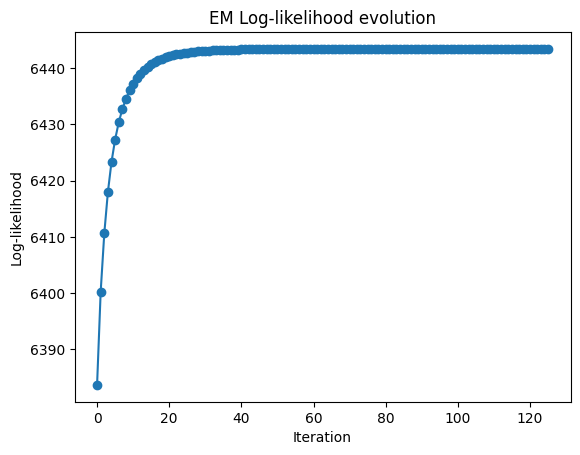

In [4]:
# Plot the log-likelihood history
import matplotlib.pyplot as plt
plt.plot(gbdm.loglik_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.title("EM Log-likelihood evolution")
plt.show()

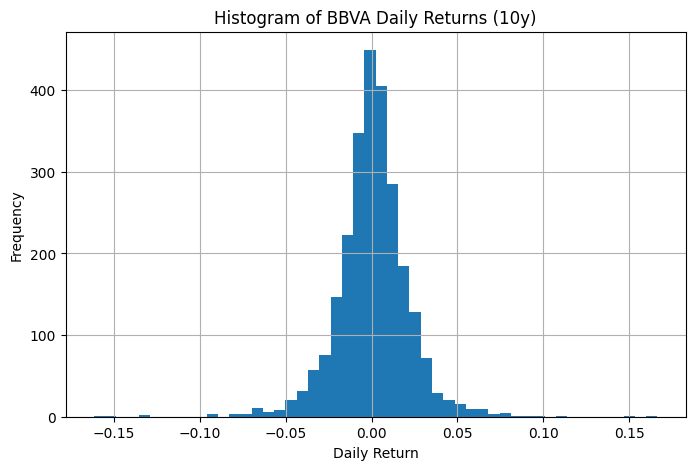

In [68]:
import matplotlib.pyplot as plt

bbva_ret.hist(bins=50, figsize=(8,5))
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.title("Histogram of BBVA Daily Returns (10y)")
plt.show()

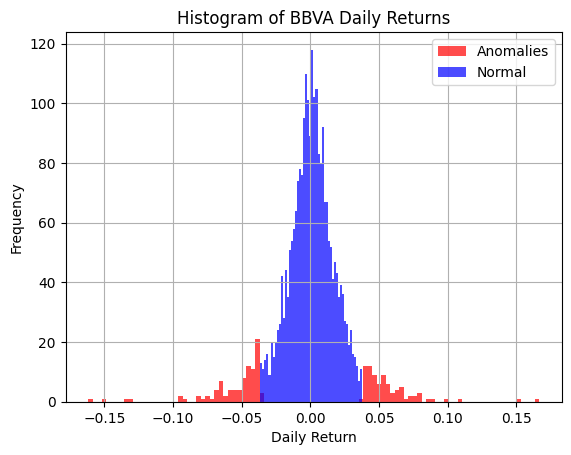

In [77]:
# Let us flag anomalies as those with 50% of more probability of belonging to the "bad data" mixture component
anomalies = (gbdm.predict(bbva_ret) > 0.5)
# Add anomaly flag to DataFrame
pd_bbva_ret = bbva_ret.reset_index()
pd_bbva_ret.columns = ["Date", "Returns"]
pd_bbva_ret["anomaly"] = anomalies

# Plot histogram of returns, segmented by anomaly flag
pd_bbva_ret[pd_bbva_ret["anomaly"] == True]["Returns"].hist(
    bins=100, alpha=0.7, color="red", label="Anomalies")
pd_bbva_ret[pd_bbva_ret["anomaly"] == False]["Returns"].hist(
    bins=50, alpha=0.7, color="blue", label="Normal")

plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.title("Histogram of BBVA Daily Returns")
plt.legend()
plt.show()


<Axes: title={'center': 'Time Series of BBVA Daily Returns'}, xlabel='Date', ylabel='Returns'>

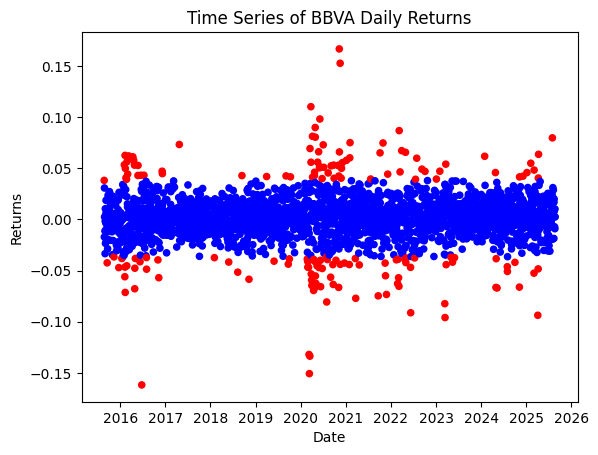

In [78]:
# In terms of time-series, we flat the anomalies in the following plot
colors = {False: "blue", True: "red"}
pd_bbva_ret.reset_index().plot.scatter(x = "Date", y = "Returns", c = pd_bbva_ret["anomaly"].map(colors).values, title = "Time Series of BBVA Daily Returns")

(0.0, 100.0)

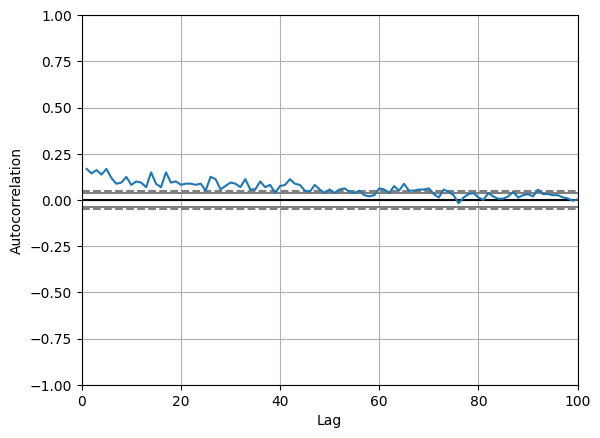

In [79]:
# An interesting question is whether these anomalies tend to cluster. Looking at the auto-correlation it hints this is a possibility
# This means it could make sense to analyse these anomalies as regime changes, i.e. use a hidden markov model
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(pd_bbva_ret["anomaly"])
ax.set_xlim([0, 100])

In [100]:
# Check that relevant periods of financial stress have been correctly classified
pd_bbva_ret["Date"] = pd.to_datetime(pd_bbva_ret["Date"]).dt.date

# Define event dates
event_dates = [
    pd.to_datetime("2020-03-16").date(),  # COVID lockdown Spain
    pd.to_datetime("2016-06-24").date(),  # Brexit referendum (first trading day)
    pd.to_datetime("2016-11-09").date()   # Trump election (first trading day after)
]

# Filter rows that match event dates
events_df = pd_bbva_ret[pd_bbva_ret["Date"].isin(event_dates)][["Date", "Returns", "anomaly"]]

print(events_df)


            Date   Returns  anomaly
214   2016-06-24 -0.161792     True
312   2016-11-09 -0.057011     True
1166  2020-03-16 -0.133684     True


##### Example 3: Local Level Model

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [23]:

def simulate_local_level(T=200, sigma_v2=1.0, sigma_w2=0.05, seed=42):
    rng = np.random.default_rng(seed)
    y = np.zeros(T)
    x = np.zeros(T)
    y[0] = rng.normal(0.0, np.sqrt(sigma_w2))
    x[0] = y[0] + rng.normal(0.0, np.sqrt(sigma_v2))
    for t in range(1, T):
        y[t] = y[t-1] + rng.normal(0.0, np.sqrt(sigma_w2))
        x[t] = y[t] + rng.normal(0.0, np.sqrt(sigma_v2))
    return x, y



def kf_rts_identity_cross(x, sigma_v2, sigma_w2, m0=0.0, P0=1e6):
    T = len(x)
    m_pred = np.zeros(T)
    P_pred = np.zeros(T)
    m_filt = np.zeros(T)
    P_filt = np.zeros(T)
    K = np.zeros(T)
    innov = np.zeros(T)
    S = np.zeros(T)

    m_prev, P_prev = m0, P0
    loglik = 0.0
    for t in range(T):
        # predict
        m_pred[t] = m_prev
        P_pred[t] = P_prev + sigma_w2
        # update
        innov[t] = x[t] - m_pred[t]
        S[t] = P_pred[t] + sigma_v2
        K[t] = P_pred[t] / S[t]
        m_filt[t] = m_pred[t] + K[t] * innov[t]
        P_filt[t] = (1 - K[t]) * P_pred[t]
        # log-likelihood
        loglik += -0.5 * (np.log(2*np.pi*S[t]) + innov[t]**2 / S[t])
        m_prev, P_prev = m_filt[t], P_filt[t]

    # RTS smoother
    m_smooth = np.zeros(T)
    P_smooth = np.zeros(T)
    J = np.zeros(T-1)
    m_smooth[-1] = m_filt[-1]
    P_smooth[-1] = P_filt[-1]
    for t in range(T-2, -1, -1):
        J[t] = P_filt[t] / P_pred[t+1]
        m_smooth[t] = m_filt[t] + J[t] * (m_smooth[t+1] - m_pred[t+1])
        P_smooth[t] = P_filt[t] + J[t]**2 * (P_smooth[t+1] - P_pred[t+1])

    # lag-one smoothed covariance via identity: P_{t-1,t|T} = J_{t-1} P_{t|T}
    P_cross = np.zeros(T-1)
    for t in range(1, T):
        P_cross[t-1] = J[t-1] * P_smooth[t]

    return {
        "m_pred": m_pred, "P_pred": P_pred,
        "m_filt": m_filt, "P_filt": P_filt,
        "m_smooth": m_smooth, "P_smooth": P_smooth,
        "innov": innov, "S": S, "K": K, "J": J,
        "P_cross": P_cross, "loglik": loglik
    }



def em_local_level(x, sigma_v2_init=2.0, sigma_w2_init=0.2, m0=0.0, P0=1e6, max_iter=500, tol=1e-8):
    sigma_v2, sigma_w2 = float(sigma_v2_init), float(sigma_w2_init)
    ll_hist = []
    for it in range(max_iter):
        out = kf_rts_identity_cross(x, sigma_v2, sigma_w2, m0, P0)
        mu, P, Pc = out["m_smooth"], out["P_smooth"], out["P_cross"]
        ll_hist.append(out["loglik"])

        # E-step expectations
        E1 = (x - mu)**2 + P
        diff_mu = mu[1:] - mu[:-1]
        E2 = diff_mu**2 + P[1:] + P[:-1] - 2.0 * Pc

        # M-step (MLE scaling)
        sigma_v2_new = max(np.mean(E1), 1e-12)
        sigma_w2_new = max(np.mean(E2), 1e-12)

        # convergence
        rel = max(abs(sigma_v2_new - sigma_v2) / (sigma_v2 + 1e-12),
                  abs(sigma_w2_new - sigma_w2) / (sigma_w2 + 1e-12))
        sigma_v2, sigma_w2 = sigma_v2_new, sigma_w2_new
        if rel < tol:
            ll_hist.append(kf_rts_identity_cross(x, sigma_v2, sigma_w2, m0, P0)["loglik"])
            break
    return {"sigma_v2": sigma_v2, "sigma_w2": sigma_w2, "ll_history": np.array(ll_hist)}



In [34]:

# --- Configuration ---
T = 200
sigma_v2_true = 1.0
sigma_w2_true = 0.05
seed = 42

# EM seeds
sigma_v2_init = 2.0
sigma_w2_init = 0.2

# --- Simulate ---
x, y = simulate_local_level(T, sigma_v2_true, sigma_w2_true, seed)

# --- Run EM ---
em = em_local_level(x, sigma_v2_init=sigma_v2_init, sigma_w2_init=sigma_w2_init, max_iter=1000, tol=1e-5)
sigma_v2_hat, sigma_w2_hat = em["sigma_v2"], em["sigma_w2"]
ll = em["ll_history"]

# --- Smooth with estimated params ---
out = kf_rts_identity_cross(x, sigma_v2_hat, sigma_w2_hat)

# --- Compare parameters ---
df = pd.DataFrame({
    "Parameter": [r"$\sigma_v^2$", r"$\sigma_w^2$"],
    "True": [sigma_v2_true, sigma_w2_true],
    "EM estimate": [sigma_v2_hat, sigma_w2_hat],
})
df


,Parameter,True,EM estimate
0,$\sigma_v^2$,1.00,0.871882
1,$\sigma_w^2$,0.05,0.054226


<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
/var/folders/d5/k0x6wwx97k7_73_1cz5q38t40000gn/T/ipykernel_39762/1804985963.py:17: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(m, label="smoothed mean $\hat{y}_{t|T}$")


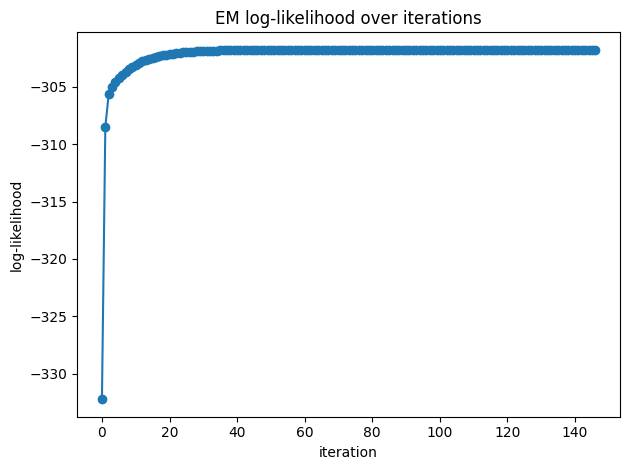

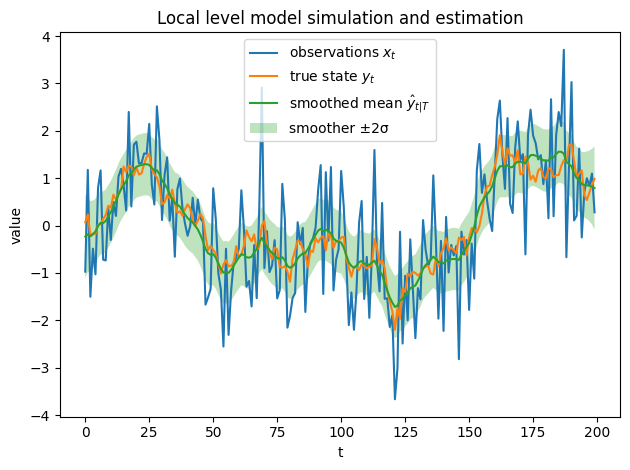

In [47]:
# Log-likelihood (should be non-decreasing up to numerical noise)
plt.figure()
plt.plot(ll, marker="o")
plt.title("EM log-likelihood over iterations")
plt.xlabel("iteration"); plt.ylabel("log-likelihood")
plt.tight_layout()
plt.show()

# Data and smoothed state with ±1σ band
t = np.arange(len(x))
m = out["m_smooth"]
std = np.sqrt(out["P_smooth"])

plt.figure()
plt.plot(x, label="observations $x_t$")
plt.plot(y, label="true state $y_t$")
plt.plot(m, label="smoothed mean $\hat{y}_{t|T}$")
plt.fill_between(t, m - 2*std, m + 2*std, alpha=0.3, facecolor="tab:green", 
                  edgecolor="none", zorder=0,label="smoother ±2σ")
plt.legend()
plt.title("Local level model simulation and estimation")
plt.xlabel("t"); plt.ylabel("value")
plt.tight_layout()
plt.show()
